In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [50]:
# Load the dataset
df = pd.read_csv("goodreads_top1000_bs.csv")

In [51]:
# === Data Preprocessing ===

df_clean = df.copy()
df_clean["Average Rating"] = df_clean["Average Rating"].str.extract(r"([0-9.]+)").astype(float)
df_clean["First Published"] = pd.to_numeric(df_clean["First Published"], errors="coerce")
genre_dummies = df_clean["Top 3 Genres"].str.get_dummies(sep=", ")

df_cluster_input = pd.concat([
    df_clean[["Average Rating", "First Published"]],
    genre_dummies
], axis=1).dropna()

In [52]:
# === K-Means Clustering ===

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_input)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster_input["Cluster"] = kmeans.fit_predict(X_scaled)

# Attach cluster info back to original data
df_clustered_books = df_clean.loc[df_cluster_input.index].copy()
df_clustered_books["Cluster"] = df_cluster_input["Cluster"]

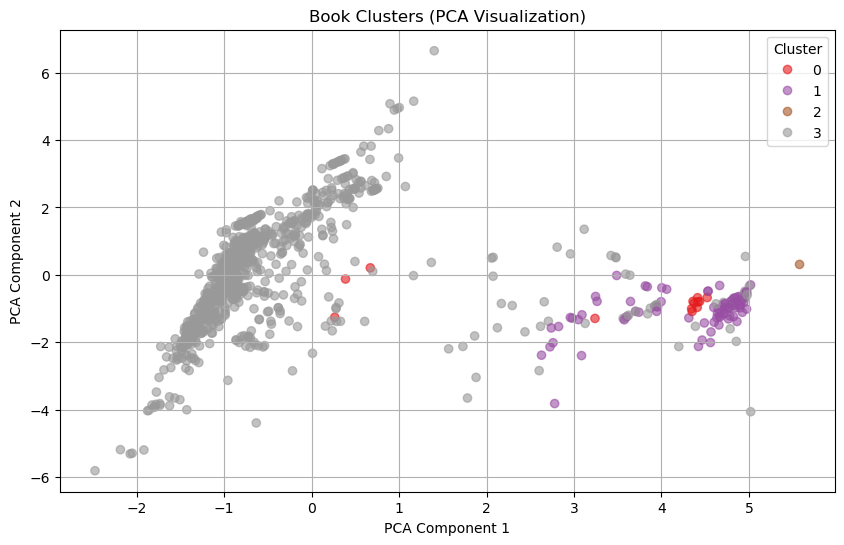

In [53]:
# === PCA Plot (optional visualization) ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cluster_input["Cluster"], cmap='Set1', alpha=0.6)
plt.title("Book Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.show()

In [ ]:
# === Recommender Function ===
def recommend_books(input_str, n=5):
    input_str = input_str.lower().strip()
    match = df_clustered_books[
        df_clustered_books["Title"].str.lower().str.strip().eq(input_str) |
        df_clustered_books["Author"].str.lower().str.strip().eq(input_str)
    ]

    if match.empty:
        return f"‚ùå No match found for '{input_str}'. Please check spelling."

    cluster_id = match.iloc[0]["Cluster"]
    recommendations = df_clustered_books[
        (df_clustered_books["Cluster"] == cluster_id) &
        ~(df_clustered_books.index.isin(match.index))
    ].sample(n=min(n, len(df_clustered_books)), random_state=42)

    # Formatting the output for better readability
    formatted_result = recommendations[["Title", "Author", "Average Rating", "Top 3 Genres", "First Published"]]
    formatted_result = formatted_result.reset_index(drop=True)
    return formatted_result

# === Prompt for user input ===
user_input = input("Enter a book title or author name: ")
result = recommend_books(user_input)

print("\nüìö Recommendations:\n")
print(result.to_string(index=False))